## Faster R-CNN 실습

## conda update
  - conda update -n base conda
  - conda update --all
  - python -m pip install --upgrade pip
  - conda --version
  
### 추가 업데이트 코드 
  - !pip install tensorflow-hub==0.10.0
  - !pip install tensorflow-estimator==2.3.0
  - !pip install pillow

### tensorflow-hub 설치
> !pip install --upgrade tensorflow-hub

In [1]:
import tensorflow as tf


# tensorflow Hub에 있는 모델들을 
# 사용할 수 있도록 도와주는 라이브러리
import tensorflow_hub as hub

# 이미지 다운로드
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# 이미지그리기
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# 시간 측정용
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.6.0
The following GPU devices are available: 


2022-04-02 11:14:43.235776: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 텐서플로우 허브 에러 날때 

  >  conda install --all

  >  에러 : tensorflow-hub error : cannot import "MomentumParameters" ....   
  >  명령어 :  pip uninstall tf-estimator-nightly tensorflow-estimator && pip install tf-estimator-nightly==2.4.0.dev2020101001
  
  
  >  환경 오류로 "Another metric with the same name already exists." 라는 오류가 뜨는 경우는 keras가 두개 이상 설치되어 있는경우이다.    
  > 해결 방법은 keras를 uninstall 하고나서 재 설치 하면 된다. 
  

In [2]:
url_to_labels = "https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt"
category_labels = []

txt_file = urlopen(url_to_labels)
for line in txt_file:
    category_labels.append(line.decode('UTF-8').rstrip("\n"))
    
print(category_labels)

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hair brush']


In [4]:
## 이미지 그려주는 부분
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False) ## 외곽선 안 보이게 하는 옵션이 False
    plt.imshow(image)
    
def download_and_resize_image(url, new_width=256, new_height=256, display=False):
    _, filename = tempfile.mkstemp(suffix=".jpg")
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    print("Image downloaded to %s." % filename)
    if display:
        display_image(pil_image)
    return filename

Image downloaded to /var/folders/6s/7_v0989s6zd829l47l_kbyj00000gn/T/tmpa15d14oj.jpg.


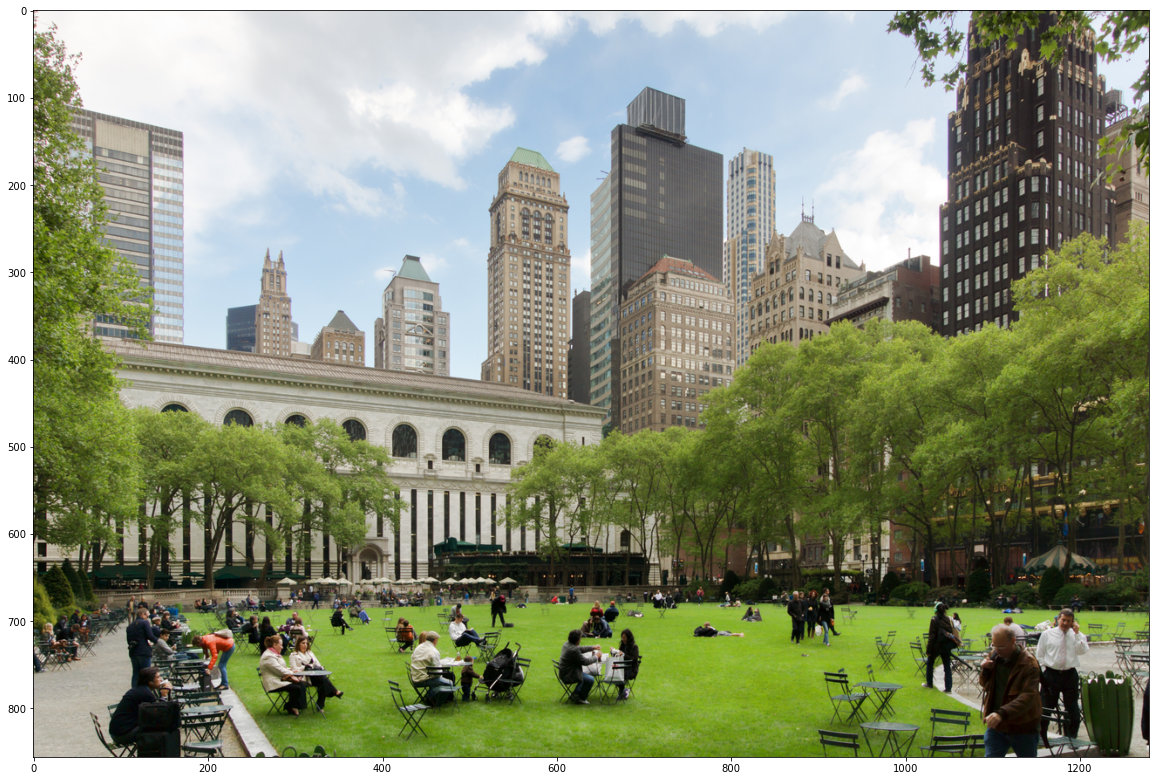

In [19]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/a/a6/New-York_-_Bryant_Park.jpg" 
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

# 
   > FasterRCNN+InceptionResNet V2: 높은 정확성    
   > ssd + mobilenet V2: 작고 빠름

## 링크
 - Tensorflow Hub에서 다양한 객체 감지 모델들을 검색 및 다운로드 가능
 - https://tfhub.dev
 - https://tfhub.dev/s?module-type=image-object-detection

In [6]:
## 위의 링크로 가 이미 COCO 이미지를 사용해 구현한 모델을 불러옴
## 1. 위 웹페이지에서 해당 모델 찾기 2. 클릭해 들어가서 copy URL 클릭 3. 모듈 변수 선헌하고 해당 URL 넣기

module_handle = "https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1"
detector = hub.load(module_handle)

In [ ]:
#module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
#detector = hub.load(module_handle).signatures['default']

In [20]:
## 객체 별 박스 그리기 함수

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width=thickness,
              fill=color)
    
    
    # 박스 설명글 배치
    # 박스 윗부분이 이미지를 벗어날 경우 
    # 글씨를 박스 아래에 위치하도록 변경
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
    
    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
        
    # 글자 나열순서를 바꿧서 위래서 아래로 그리기
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin

In [21]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.4): 
## max_boxes=10, min_score=0.4 수정하면서 결과를 다르게 볼 수도 있음
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())
    
    font = ImageFont.load_default()
    
    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(category_labels[int(class_names[i])-1],int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
                image_pil,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

In [22]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [17]:
converted_img  = tf.image.convert_image_dtype(path, tf.uint8)[tf.newaxis, ...]
print(converted_img[8])

NameError: name 'path' is not defined

In [18]:
category_labels

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'street sign',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'hat',
 'backpack',
 'umbrella',
 'shoe',
 'eye glasses',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'plate',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'mirror',
 'dining table',
 'window',
 'desk',
 'toilet',
 'door',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'blender',
 'book',
 'clock',
 'vase',
 'scis

In [23]:
def run_detector(detector, path):
    img = load_img(path)

    converted_img  = tf.image.convert_image_dtype(img, tf.uint8)[tf.newaxis, ...] ## 이미지 앞에 숫자를 넣어주며 순서의 의미를 준다고 하심
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()
    
    result = {key:value.numpy() for key,value in result.items()}
    
    
    print("Found %d objects." % len(result["detection_scores"][0]))
    print("Inference time: ", end_time-start_time)
    
    image_with_boxes = draw_boxes(
        img.numpy(), result["detection_boxes"][0],
        result["detection_classes"][0], result["detection_scores"][0])
    
    display_image(image_with_boxes)

Found 100 objects.
Inference time:  7.883603096008301


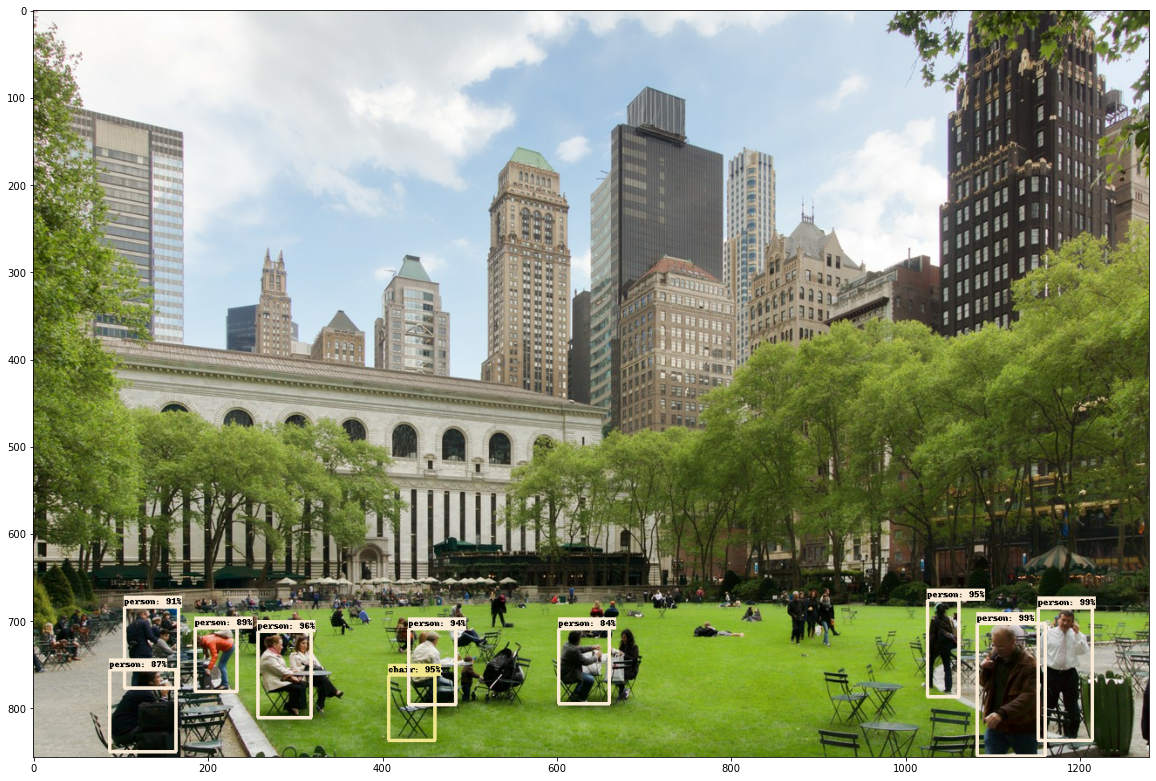

In [24]:
run_detector(detector, downloaded_image_path)

Image downloaded to /var/folders/6s/7_v0989s6zd829l47l_kbyj00000gn/T/tmpg_nsqju3.jpg.
Found 100 objects.
Inference time:  8.311767816543579


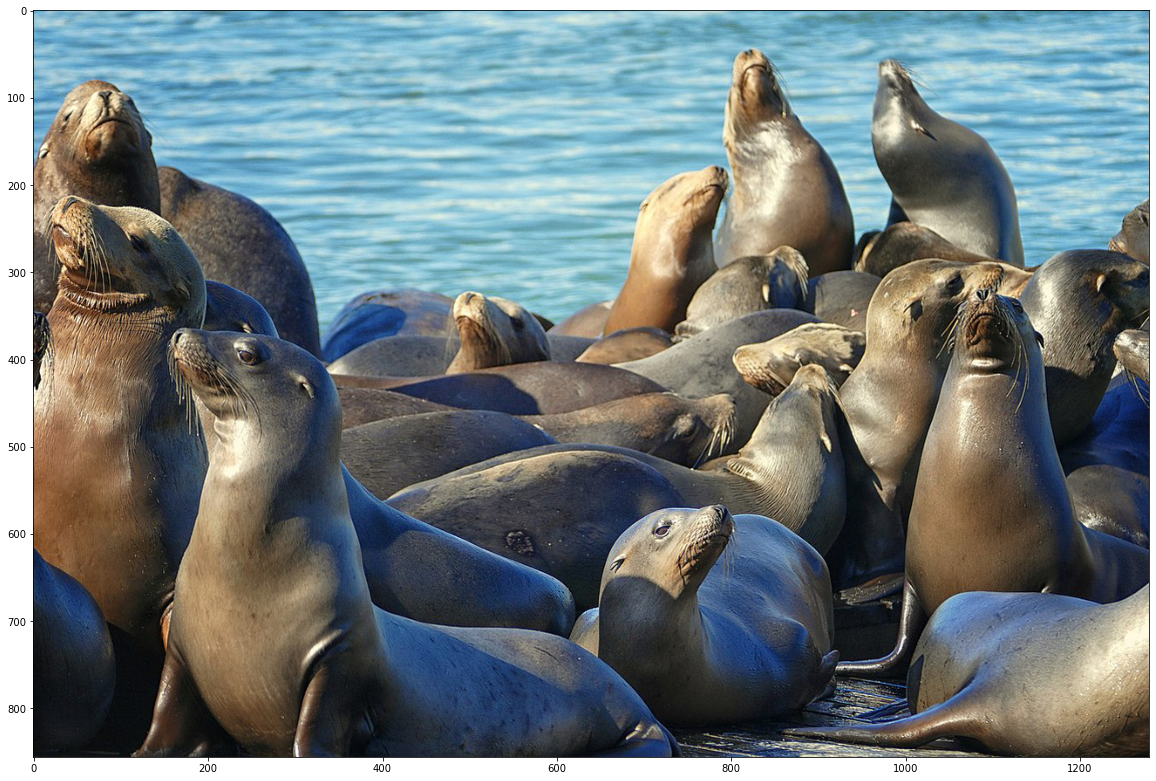

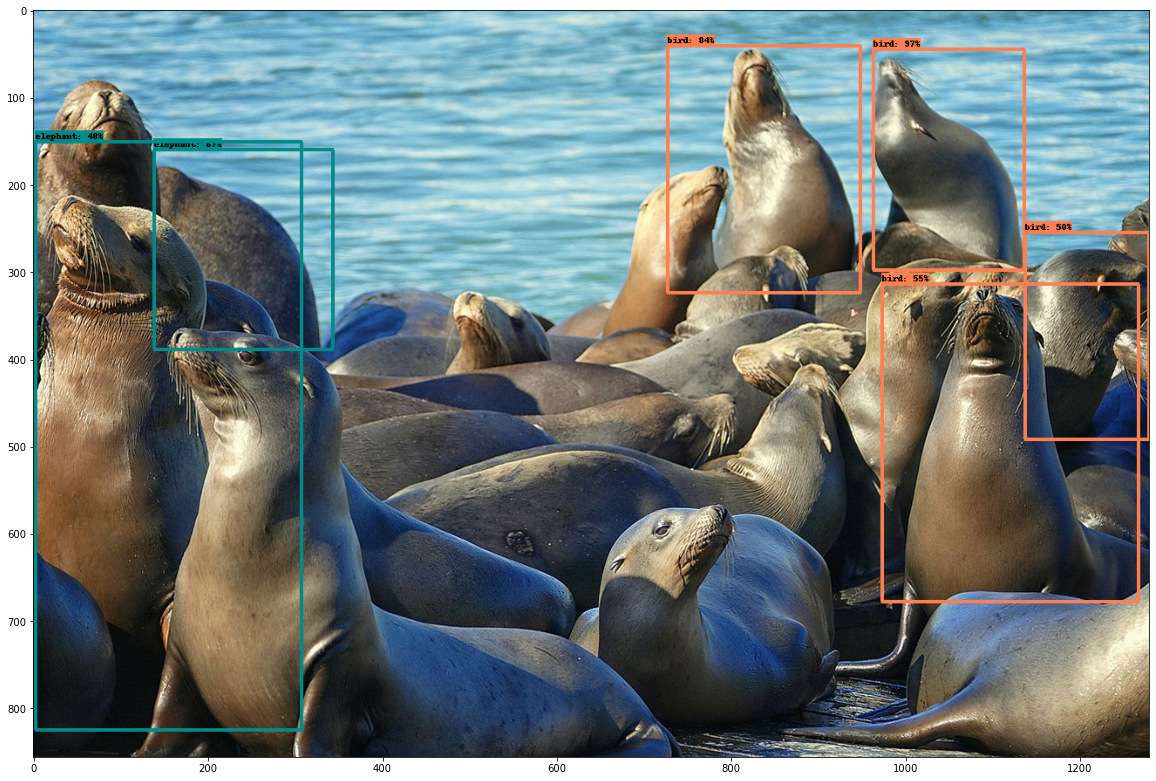

In [25]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Pinnipedia_2015-10-31_%28181602085%29.jpg/1280px-Pinnipedia_2015-10-31_%28181602085%29.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)
run_detector(detector, downloaded_image_path)